In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from gempy import coKriging
from gempy import GridClass
import pandas as pd
from numpy import random
import sklearn.preprocessing as skp
import pymc3 as pm
import theano.tensor as T

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [2]:
SED_f = gp.coKriging.theano_sed()

In [3]:
def create_sgs_dataframe(geomodel, grid, formation):
    """
    Method to create a new pandas dataframe combining Input Data for SGS CoKriging
    Does not include property data for variogram analysis and interpolation. Thus independent
    of amount of Input properties.
    Args:
        geomodel (numpy.ndarray): lithological block model created with gempy
        grid (gempy.data_management.GridClass): Grid created for geologic model
        formation (int): Number of formation to perform CoKriging on
    Returns
        pandas.dataframe: Combined dataframe with all relevant data
    """
    
    # convert lith block values to int, need to do this properly - uncorrect as of now
    lith_block_int = np.round(lith_block)
    
    # create the dataframe and populate with data
    d = {'X': grid.values[:,0], 'Y': grid.values[:,1], 'Z': grid.values[:,2], 'lith': lith_block_int[0]}
    df_cokr = pd.DataFrame(data=d)
    
    df_sgs_grid = df_cokr.loc[df_cokr['lith'] == formation]
    df_sgs_grid = df_sgs_grid.reset_index() # reset indicies
    del df_sgs_grid['index'] # reset indices
    
    return df_sgs_grid

In [4]:
def create_synthetic_Input_data(n_prop, n_samples, grid):
    '''
    This Part is used to create synthetic Input data. It is possible to vary the number of properties
    and the number of samples. Right now every assigned value is a random value between 0 and 100.
    Data is thus in no way spatially correlated, which makes the Kriging kind of useless, but works for
    testing purposes. Only an isotopic case is realized. Max 10 properties can be used due to a.
    Args: 
        n_prop (int): Number of properties that we have data for
        n_samples (int): Number of sample locations, were we have data for every property (isotopic)
    Returns:
        df_prop(pandas.dataframe): dataframe containing x,y,z coordinates and data for n properties
    '''
    # copy to leave original grid intact
    data_loc_aux = df_cokr_cut.copy()

    # create dataframe with coordinates and n properties
    d = ['X', 'Y', 'Z']
    df_prop = pd.DataFrame(columns=d)
    df_prop

    a=['prop1','prop2','prop3','prop4', 'prop5','prop6','prop7','prop8','prop9','prop10']

    for t in range (n_prop):
        df_prop[a[t]]=""

    df_prop

    for i in range(n_samples):
            # choose random point from df_sgs_grid_calc
            rand_pos = np.random.randint(0,len(data_loc_aux))
            random_coord = np.array([data_loc_aux.loc[rand_pos,'X'],data_loc_aux.loc[rand_pos,'Y'],data_loc_aux.loc[rand_pos,'Z']])

            # delete point from the df sgs_grid_calc
            data_loc_aux = data_loc_aux.drop([rand_pos])
            data_loc_aux = data_loc_aux.reset_index() # reset indicies
            del data_loc_aux['index'] #reset indices

            # pick random coordinate from grid
            data_point=([random_coord[0], random_coord[1], random_coord[2]])

            # put random data in 
            #for r in range(n_prop):
            #    data_point.append(np.random.randint(1,100))
            
            data_point.append(0.00001*np.random.normal(1,1)/35)
            data_point.append((13.7+np.random.normal(20,3))*3)
            data_point.append(np.random.normal(3,10)*2)
            data_point.append(np.random.normal(100,50)+2.23462)
            data_point.append(5.234*np.random.normal(25,2))

            df_prop.loc[i]=data_point
            # create random data for the properties

    return df_prop

In [5]:
def select_closest_points(coord, df):
    """
    Method to select n closest points from the given coordinate to perform Cokriging with reasonable calculation
    time
    Args:
        coord (np.array): coordinates of point
        df (pandas.dataframe): dataframe containing coordinated and properties
    Returns
        df_cut (pandas.dataframe): dataframe containing only the 50 closest points
    """
    
    selected_coord_data = df[['X', 'Y', 'Z']]
    # selected_values_data = df[df.columns.difference(['X', 'Y', 'Z'])].as_matrix()
    
    dist = SED_f(selected_coord_data, coord) # Miguels distance function, applied to input data
    
    for r in range(100, 5000, 100):
        closest_points = (dist < r).any(axis=1)
        if closest_points.sum() > 50:
            break
    
    return closest_points

In [6]:
def cross_cov_sample(df, exp_var, lags):
    """
    method to pick sample from Miguels crazy crossvariogram fitting, mostly copied
    """
    n_exp = 2
    n_gaus = 2
    n_var = df.columns.shape[0]
    n_basis_f = n_var * (n_exp + n_gaus)
    prior_std_reg = df.std(0).max() * 10
    #
    range_mu = lags.mean()

    # Because is a experimental variogram I am not going to have outliers
    nugget_max = df.values.max()
    # print(n_basis_f, n_var*n_exp, nugget_max, range_mu, prior_std_reg)
    # pymc3 Model
    with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        sigma = pm.HalfCauchy('sigma', beta=prior_std_reg, testval=1., shape=n_var)

        psill = pm.Normal('sill', prior_std_reg, sd=.5 * prior_std_reg, shape=(n_exp + n_gaus))
        range_ = pm.Normal('range', range_mu, sd=range_mu * .3, shape=(n_exp + n_gaus))
        #  nugget = pm.Uniform('nugget', 0, nugget_max, shape=n_var)

        lambda_ = pm.Uniform('weights', 0, 1, shape=(n_var * (n_exp + n_gaus)))

        # Exponential covariance
        exp = pm.Deterministic('exp',
                               # (lambda_[:n_exp*n_var]*
                               psill[:n_exp] *
                               (1. - T.exp(T.dot(-lags.as_matrix().reshape((len(lags), 1)),
                                                 (range_[:n_exp].reshape((1, n_exp)) / 3.) ** -1))))

        gaus = pm.Deterministic('gaus',
                                psill[n_exp:] *
                                (1. - T.exp(T.dot(-lags.as_matrix().reshape((len(lags), 1)) ** 2,
                                                  (range_[n_exp:].reshape((1, n_gaus)) * 4 / 7.) ** -2))))

        func = pm.Deterministic('func', T.tile(T.horizontal_stack(exp, gaus), (n_var, 1, 1)))

        func_w = pm.Deterministic("func_w", T.sum(func * lambda_.reshape((n_var, 1, (n_exp + n_gaus))), axis=2))
        #           nugget.reshape((n_var,1)))
        '''
        for e, cross in enumerate(df.columns):
            # Likelihoods
            pm.Normal(cross + "_like", mu=func_w[e], sd=sigma[e], observed=df[cross].as_matrix())
        '''
    return model

    

In [7]:
def perform_sgs(property_data, sgs_grid, exp_var):
    """
    Method to perform the SGS run, creating a new dataframe with the resulting grid, 
    containing the interpolated data fro the CoKriging
    Args:
        property_data (pandas.datframe): frame containing property data with corresponding X,Y,Z coordinates
        sgs_grid (pandas.dataframe): frame containing grid, meaning all X,Y,Z coordinates in domain 
    Returns:
        Result: Dataframe containg all interpolated values with corresponding coordinates       
    """
    
    # Normalization, compared to Miguels code all properties "have" to be used
    # Turn Nans to 0, workaround
    exp_var_aux = exp_var.copy()
    exp_var_aux.fillna(value=0, inplace=True)
    aux = exp_var_aux.drop('lags', axis=1)
    
    scaled_data = pd.DataFrame(skp.minmax_scale(aux))

    # Nuggets
    nuggets = scaled_data.iloc[0].as_matrix()
    processed_data = scaled_data - nuggets
    
    lags=exp_var['lags']
    
    model = cross_cov_sample(scaled_data, exp_var, lags)
    if True:
        with model:
            start = pm.find_MAP()  # Find starting value by optimization
            step = pm.Metropolis()
            #db = pm.backends.SQLite('SQtry.sqlite')
            trace = pm.sample(100, step, init=start, progressbar=True, njobs=1)
    if False:
        sgs.plot_cross_covariance(iter_plot=1800)
        
        
    # new dataframe for all results
    results = pd.DataFrame(columns=property_data.columns)
    n_var = len(results.columns)-3
    
    # both Input dfs should not be changed
    df_prop_calc = property_data.copy() #copy dataframe for appending results for SGS
    df_sgs_grid_calc = sgs_grid.copy() #copy of grid frame to delete data
    
    for i in range(0, len(sgs_grid)):
        
        # choose random point from df_sgs_grid_calc
        rand_pos = np.random.randint(0,len(df_sgs_grid_calc))
        random_coord = np.array([df_sgs_grid_calc.loc[rand_pos,'X'],df_sgs_grid_calc.loc[rand_pos,'Y'],df_sgs_grid_calc.loc[rand_pos,'Z']])
        
        # workaround to turn coord into df to make it work with Miguels Code
        coord_aux={'X':[random_coord[0]], 'Y':[random_coord[1]], 'Z':[random_coord[2]]}
        rand_coord_df=pd.DataFrame(data=coord_aux)
        
        # delete point from the df sgs_grid_calc
        df_sgs_grid_calc = df_sgs_grid_calc.drop([rand_pos])
        df_sgs_grid_calc = df_sgs_grid_calc.reset_index() # reset indicies
        del df_sgs_grid_calc['index'] #reset indices
        
        # only select n closest points for Cokriging,best by selection to make it work with miguels code
        df_prop_calc_close = select_closest_points(rand_coord_df, df_prop_calc)
        
        # perform the CoKriging interpolation on this point
        kriging_results = CoKriging_real(rand_coord_df, df_prop_calc, df_prop_calc_close, n_var, nuggets, trace) 
        
        #just for testing purposes, we get this from the Kriging Results
        # good enough, lets see what the Kriging results really look like
        krig_mean = np.ndarray(shape=(n_var,2))
        krig_std = np.ndarray(shape=(n_var,2))
        
        # set coordinates in result array
        new_interpolated_point = ([random_coord[0], random_coord[1],random_coord[2]])
        
        # add property interpolation to results array, depends a little bit on form of Kriging results
        for j in range(n_var):
            new_interpolated_point.append(np.random.normal(krig_mean[j][0],krig_std[j][1]))
                            
        # append result to df_prop_calc to use for further SGS
        df_prop_calc.loc[len(df_prop_calc)]=new_interpolated_point
        
        # append results to final results dataframe that will be returned
        results.loc[len(results)]=new_interpolated_point
        
    return results

In [23]:
#wtf

def CoKriging_real(coord_to_inter, df_prop_data, selection, n_properties, nuggets, trace):
    """
    Method to perform Cokriging at one point based on a set of input points, considering multiple variables
    Args:
        coord_to_interpolate: X,Y,Z coordinates of point where properties should be interpolated
        property_data: dataset of property data for interpolation (including coordinates)
        variogram_data (?)
    Returns:
        x (np.array): Array with results of interpolation, including x,y,z coord and interpolated property data
    """
    
    # Select input data and compute its euclidean distances
    selected_coord_data = df_prop_data[selection][['X', 'Y', 'Z']]
    selected_values_data = df_prop_data[selection][df_prop_data.columns.difference(['X', 'Y', 'Z'])].as_matrix()
    h_A = SED_f(selected_coord_data, selected_coord_data)
    
    # Select points of grid to interpolate and compute the euclidean distances respect the input data
    selected_grid_to_inter = coord_to_inter 
    h_b = SED_f(selected_coord_data, selected_grid_to_inter)
    
    # Nuggets are now in as parameter
    # as well as trace
    n_properties = 25
    # should be correct
    n_var = int(np.sqrt(n_properties)) 
    
    # no idea but thats Miguels standard
    n_exp = 2
    n_gauss = 2

    # why - I am supposed to just pick medium trace I think
    # Choose a random trace to conserve the covariance uncertainty of the regression
    sample = np.random.randint(trace['weights'].shape[0] - 100, trace['weights'].shape[0])

    # If input data is correct, this can stay
    # Compute cross-covariances
    cov_h = coKriging.cross_covariance(trace, h_A, sample=sample,
                                nuggets=nuggets, n_var=n_var, n_exp=n_exp, n_gaus=n_gauss, ordinary=True)
    cov_b = coKriging.cross_covariance(trace, h_b, sample=sample, nuggets=nuggets, n_var=n_var, n_exp=n_exp,
                                n_gaus=n_gauss,
                                ordinary=True)
    
    
    # If input data is correct, this can stay
    # Solve kriging system
    try:
        k_weights = np.linalg.solve(cov_h, cov_b)
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            k_weights = np.zeros((len(cov_b), 1))
        else:
            raise
    
    print(k_weights[1])
    # k_weights = np.linalg.solve(cov_h, cov_b)
    
    # dont know what this is and if its necessary if i do not take random covariance function
    # Number of points to interpolate
    npti = selected_grid_to_inter.shape[0]

    # dont know what this is and if its necessary if i do not take random covariance function
    # Repeat the input data for every point to interpolate
    svd_tmp = np.tile(np.repeat(selected_values_data, npti, axis=1), (n_var, 1))

    # this should work
    # Sol ordinary kriging mean
    k_mean = (svd_tmp * k_weights[:-n_var]).sum(axis=0)

    # this should work
    # Sol ordinary kriging std
    k_std = svd_tmp.std(axis=0) - (k_weights * cov_b)[:-n_var].sum(axis=0) +\
            (k_weights * cov_b)[-n_var:].sum(axis=0)

    # not sure if the following part is necessary
    '''assert all(k_std) > -10, "A standard deviation of kringing is really off. Check nothing is wrong"
    # Set negatives to 0
    k_std[k_std < 0] = 0.1

    # Check the results make sense else take another sample and recompute
    import scipy
    l_low, l_high = scipy.stats.norm.interval(.95, loc=np.mean(selected_values_data, axis=0),
                                                scale=np.std(selected_values_data, axis=0))

    if not np.all((k_mean > l_low) * (k_mean < l_high)):

        k_mean, k_std, cov_h, cov_b, k_weights, sample = self.solve_kriging(selection_A, selection_b)
        self._recursion_check += 1
        assert self._recursion_check<500, 'Too many recursions. Probably something goes wrong'

    else:
        self._recursion_check = 0
        values_interp = np.random.normal(k_mean, k_std)'''

    return k_mean, k_std, cov_h, cov_b, k_weights#, sample

In [9]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_interfaces") # importing point-positional interface data

In [10]:
# gp.get_data(geo_data)

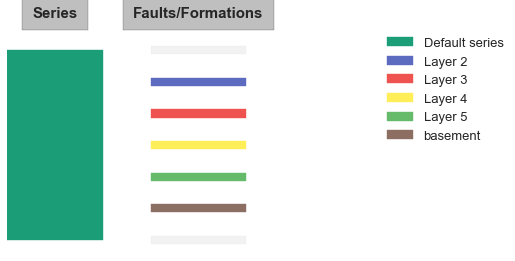

In [11]:
%matplotlib inline
gp.get_sequential_pile(geo_data)

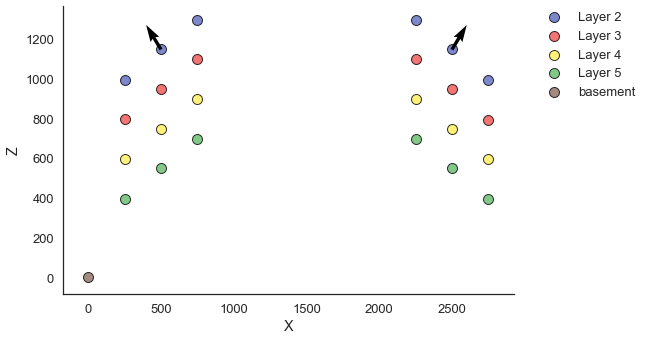

In [12]:
%matplotlib inline
gp.plotting.plot_data(geo_data, direction='y')

In [13]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')
#print(interp_data)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [14]:
lith_block, fault_block = gp.compute_model(interp_data)

In [15]:
df_cokr_cut = create_sgs_dataframe(lith_block[0],geo_data.grid, formation=3)

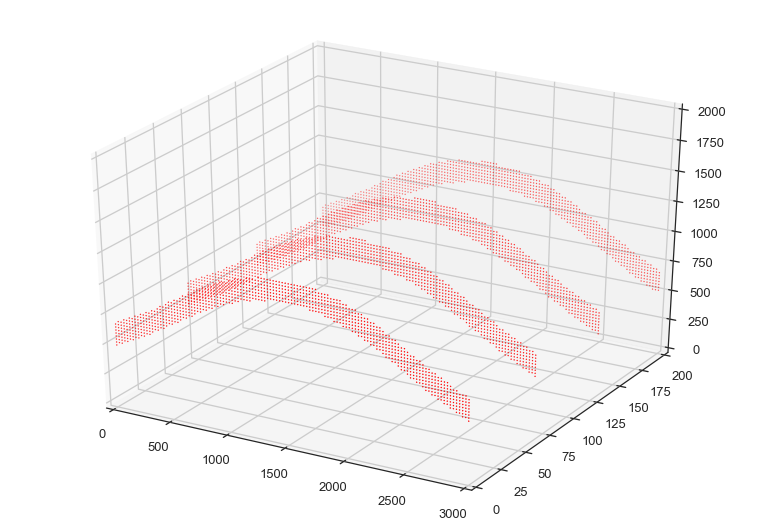

In [16]:
# visualization of grid, cut down to one lithology
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=df_cokr_cut.X,ys=df_cokr_cut.Y,zs=df_cokr_cut.Z, c=df_cokr_cut.lith, s=1, cmap='prism')

In [17]:
#section plotted in classical gempy plot_section for comparison

#%matplotlib inline
#gp.plotting.plot_section(geo_data, lith_block[0], cell_number=0,  direction='y', plot_data=False)

In [18]:
number_of_properties=5
number_of_samples=1000

df_prop = create_synthetic_Input_data(number_of_properties, number_of_samples, df_cokr_cut)
df_prop.head()

,X,Y,Z,prop1,prop2,prop3,prop4,prop5
0,2362.5,66.944443,887.025330,2.041271e-07,121.297538,-13.808002,134.546224,125.552342
1,287.5,0.833333,736.392395,9.597705e-08,99.713445,-1.707133,161.269458,130.222901
2,2912.5,66.944443,711.286926,5.237336e-07,100.833325,-13.625490,84.540242,125.901583
3,2512.5,0.833333,912.130798,2.051214e-07,113.717660,5.872672,-6.617773,138.925816
4,1112.5,66.944443,1138.080200,5.960970e-07,97.575306,11.753256,79.110280,158.336959


In [19]:
# Dirty workaround to be able to compute variograms for n properties
a=['prop1','prop2','prop3','prop4', 'prop5','prop6','prop7','prop8','prop9','prop10']
properties = a[:number_of_properties]

exp_var = gp.coKriging.compute_crossvariogram(df_prop, properties)
exp_var.head()

C:\Users\Jan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,prop1-prop1,prop1-prop2,prop1-prop3,prop1-prop4,prop1-prop5,prop2-prop1,prop2-prop2,prop2-prop3,prop2-prop4,prop2-prop5,...,prop4-prop2,prop4-prop3,prop4-prop4,prop4-prop5,prop5-prop1,prop5-prop2,prop5-prop3,prop5-prop4,prop5-prop5,lags
0,0.0,5111.737314,216.198218,6389.695264,8629.676625,5111.737314,0.0,4740.087767,1230.218923,550.817709,...,1230.218923,6036.228877,0.0,1689.017471,8629.676625,550.817709,8080.86126,1689.017471,0.0,1.000000
1,0.0,5111.737314,216.198218,6389.695264,8629.676625,5111.737314,0.0,4740.087767,1230.218923,550.817709,...,1230.218923,6036.228877,0.0,1689.017471,8629.676625,550.817709,8080.86126,1689.017471,0.0,1.064786
2,0.0,5111.737314,216.198218,6389.695264,8629.676625,5111.737314,0.0,4740.087767,1230.218923,550.817709,...,1230.218923,6036.228877,0.0,1689.017471,8629.676625,550.817709,8080.86126,1689.017471,0.0,1.133769
3,0.0,5111.737314,216.198218,6389.695264,8629.676625,5111.737314,0.0,4740.087767,1230.218923,550.817709,...,1230.218923,6036.228877,0.0,1689.017471,8629.676625,550.817709,8080.86126,1689.017471,0.0,1.207222
4,0.0,5111.737314,216.198218,6389.695264,8629.676625,5111.737314,0.0,4740.087767,1230.218923,550.817709,...,1230.218923,6036.228877,0.0,1689.017471,8629.676625,550.817709,8080.86126,1689.017471,0.0,1.285433


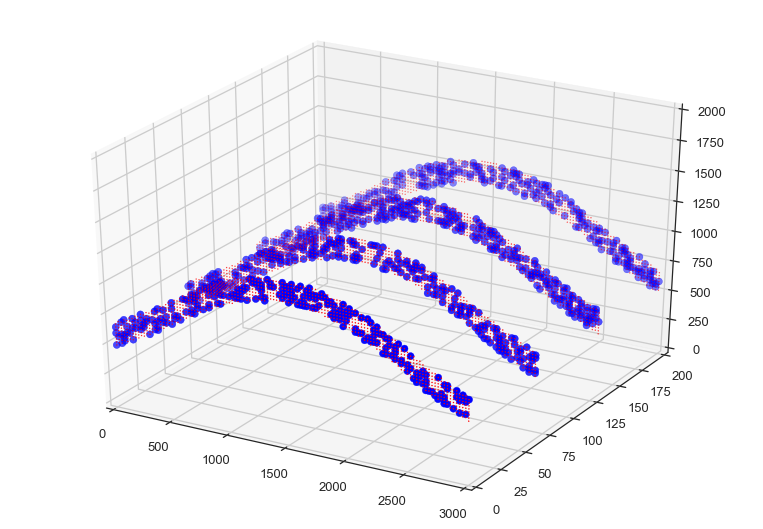

In [20]:
# visualization of grid, cut down to one lithology, as well as property Input data from dataframe
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=df_cokr_cut.X,ys=df_cokr_cut.Y,zs=df_cokr_cut.Z, c=df_cokr_cut.lith, s=1, cmap='prism')
ax.scatter3D(xs=df_prop.X,ys=df_prop.Y,zs=df_prop.Z, c='blue', s=50)

In [24]:
%%time
results = perform_sgs(df_prop, df_cokr_cut, exp_var)

logp = -74.195, ||grad|| = 0.0018525: 100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 1001.23it/s]
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [weights_interval__]
>Metropolis: [range]
>Metropolis: [sill]
>Metropolis: [sigma_log__]
100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 936.57it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


[ 6.27135486e-16  3.85985281e-17 -2.33506241e-15  1.09167008e-16
 -5.21473991e-16]
[-0.35835529  0.09596506 -0.29049338 -0.01268429 -0.22826501]
[ 0.07577525 -0.03262406  0.06185372  0.01417652  0.00144412]
[ 0.00186133  0.00059441 -0.00233897  0.00046548  0.00143552]
[-0.01036246  0.00426901 -0.00314722 -0.00122462  0.01948312]
[ 0.00078783 -0.00248329  0.00126679 -0.00102777 -0.00471879]
[ 0.00861042 -0.01012646 -0.00130084  0.00594957 -0.01408517]
[-1.09516479e-15 -1.12117325e-15  4.44262234e-15  4.88928247e-16
 -5.38271137e-17]
[ 0.06779362 -0.01940468  0.01719827 -0.05165276 -0.03888067]
[-0.00556116  0.00042275 -0.01251611  0.0039015  -0.00032632]
[ 0.01825398 -0.42533058  0.85902431 -0.26346964 -0.62847451]
[-1.87629578e-15 -6.26330053e-15 -4.22877293e-15  5.80696208e-15
  6.18718916e-15]
[ 0.00400368 -0.00144647 -0.00224364  0.00309634  0.00499091]
[-17.75050098  -0.91717041 -46.94567301   0.14143878   2.96765567]
[ 3.29549145  0.30035586 -3.66120473 -0.17239897 -0.83418044]
[-

[  0.18822585  -0.90480974   1.05209877   0.11478808 -14.57471751]
[-1271.19214219 -1711.86115847   111.51561914    16.74543004
   591.06032865]
[ 0.0147626  -0.00724929 -0.00482681 -0.00133114 -0.0109143 ]
[0.]
[0.]
[-2702.74525142  2537.34191185 -1613.03111914 -9134.56741819
   -72.32733399]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[  145.550941     -95.72762188    84.00567307  -200.74527765
 45143.74185987]
[ 8.95444876e-03  4.82820126e-05 -7.48947572e-04  1.40000724e-03
 -2.12721410e-04]
[ -215.44111351   -10.00805224  -138.59447025 -1826.39279141
  -909.56067782]
[-2.59819100e+00  1.14833270e+02 -9.44719002e+01  1.40831457e+01
  1.75688789e+04]
[-120.95137774  -86.62095599  972.59620487  472.43933141 -192.65477164]
[0.]
[0.]
[-157.18704044    1.80503364  -61.14679201   -0.22475622  -37.99712739]
[0.]
[0.]
[-6.27015576 -1.26202548  4.17719545  5.54723758  3.81155164]
[-3.21505083e+16 -4.61940054e+18 -1.76579034e+18 -2.95398955e+20
 -1.05139295e+16]
[0.]
[2072.76660453   44.42475359 -118.37757

KeyboardInterrupt: 

NameError: name 'results' is not defined

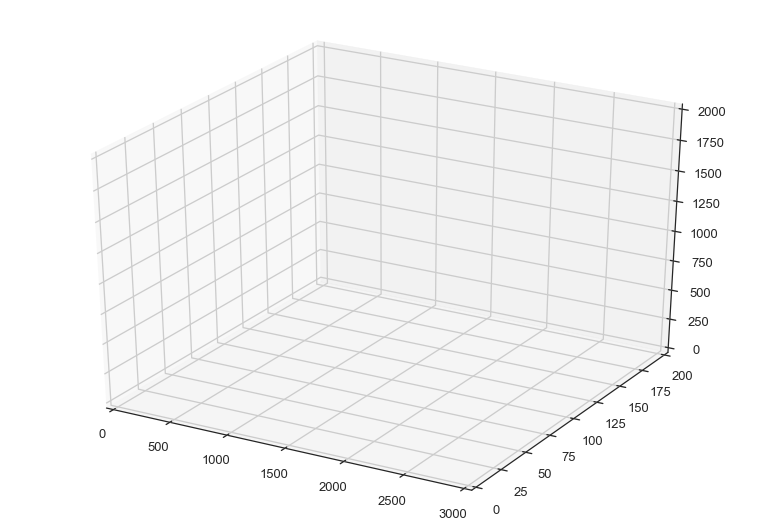

In [22]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=results.X,ys=results.Y,zs=results.Z, c=results.prop1, s=1, cmap='prism')
ax.scatter3D(xs=df_prop.X,ys=df_prop.Y,zs=df_prop.Z, c='blue', s=50)

In [ ]:
results.shape

In [ ]:
results.head()